# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale
from skimage.util import crop
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K

In [4]:
# source_path = 'Project_data/'
source_path = '../input/gesture-recognition/gesture_recognition/'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open(source_path + 'train.csv').readlines())
val_doc = np.random.permutation(open(source_path + 'val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
img_height = 120
img_width = 120
img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,21,23,25,27,29]
img_shape = (len(img_idx), img_height, img_width, 3)
num_classes = 5

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx), img_height, img_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    if image.shape == (120, 160, 3):
                        image = crop(image, ((0, 0), (20, 20), (0,0)), copy=False)
                    elif image.shape == (360, 360, 3):
                        image = rescale(image, 1/3, multichannel=True, mode='constant')
                        
                    batch_data[folder,idx,:,:,0] = ( image[:,:,0] - np.mean(image[:,:,0]) ) / ( np.max(image[:,:,0]) - np.min(image[:,:,0]) )
                    batch_data[folder,idx,:,:,1] = ( image[:,:,1] - np.mean(image[:,:,1]) ) / ( np.max(image[:,:,1]) - np.min(image[:,:,1]) )
                    batch_data[folder,idx,:,:,2] = ( image[:,:,2] - np.mean(image[:,:,2]) ) / ( np.max(image[:,:,2]) - np.min(image[:,:,2]) )
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        sequences_left = len(t) % batch_size
        batch_data = np.zeros((sequences_left, len(img_idx), img_height, img_width, 3))
        batch_labels = np.zeros((sequences_left, num_classes))
        for folder in range(sequences_left):
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): 
                image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                #crop the images and resize them. Note that the images are of 2 different shape 
                if image.shape == (120, 160, 3):
                    image = crop(image, ((0, 0), (20, 20), (0,0)), copy=False)
                elif image.shape == (360, 360, 3):
                    image = rescale(image, 1/3, multichannel=True, mode='constant')

                batch_data[folder,idx,:,:,0] = ( image[:,:,0] - np.mean(image[:,:,0]) ) / ( np.max(image[:,:,0]) - np.min(image[:,:,0]) )
                batch_data[folder,idx,:,:,1] = ( image[:,:,1] - np.mean(image[:,:,1]) ) / ( np.max(image[:,:,1]) - np.min(image[:,:,1]) )
                batch_data[folder,idx,:,:,2] = ( image[:,:,2] - np.mean(image[:,:,2]) ) / ( np.max(image[:,:,2]) - np.min(image[:,:,2]) )

            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = source_path + 'train'
val_path = source_path + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, InputLayer, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNetV2

base_model_mobilnet = MobileNetV2(weights='imagenet',include_top=False)

model = Sequential()

# Input layer to accept image sequence with the shape of our sequence
model.add(InputLayer(input_shape=img_shape))

# Adding mobileNet for transfer learning - to use as a CNN
model.add(TimeDistributed(base_model_mobilnet))
model.add(TimeDistributed(Dropout(0.3)))
model.add(TimeDistributed(GlobalAveragePooling2D()))

# Adding GRU layer with Dropouts
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, dropout=0.25))

model.add(Dense(num_classes, activation = "softmax", kernel_regularizer='l1'))

2022-04-12 09:25:31.921813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 09:25:31.932116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 09:25:31.932849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 09:25:31.933955: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.SGD(learning_rate=0.05)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1280)    2257984   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1280)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1280)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1280)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               541440    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 2,800,069
Trainable params: 2,765,957
Non-trainable params: 34,112
_________________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=1, min_lr=0.0001, mode='auto', verbose=1, cooldown=2)
# callbacks_list = [checkpoint, LR]
callbacks_list = [checkpoint]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesture-recognition/gesture_recognition/train ; batch size = 32


2022-04-12 09:25:38.732106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-12 09:25:44.915831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


21/21 [==============================] - 134s 6s/step - loss: 1.6662 - categorical_accuracy: 0.5943 - val_loss: 2.7352 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 2.73525, saving model to model_init_2022-04-1209_25_31.857943/model-00001-1.66620-0.59427-2.73525-0.38000.h5
Epoch 2/30
21/21 [==============================] - 115s 6s/step - loss: 0.8653 - categorical_accuracy: 0.9095 - val_loss: 2.1234 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 2.73525 to 2.12338, saving model to model_init_2022-04-1209_25_31.857943/model-00002-0.86529-0.90950-2.12338-0.45000.h5
Epoch 3/30
21/21 [==============================] - 116s 6s/step - loss: 0.6345 - categorical_accuracy: 0.9774 - val_loss: 1.8404 - val_categorical_accuracy: 0.5700

Epoch 00003: val_loss improved from 2.12338 to 1.84044, saving model to model_init_2022-04-1209_25_31.857943/model-00003-0.63445-0.97738-1.84044-0.57000.h5
Epoch 4/30
21/21 [==============================]

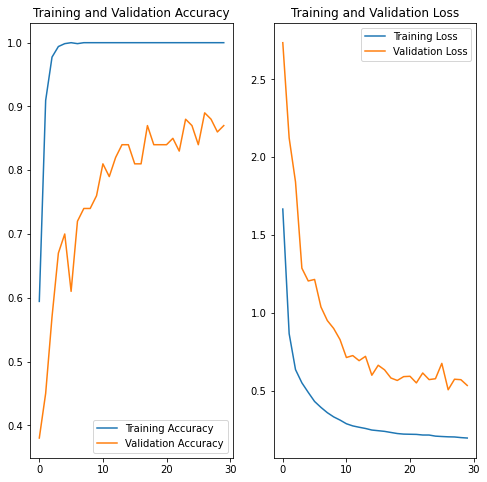

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion
The model has learnt well. 
1. The validation loss is decreasing and plateaus around 0.5
2. Running this model for more epochs won't yeild any benefits as the validation loss has already plateau-ed
3. The training accuracy has reached a perfect score of 1, the validation accuracy follows closely at 0.89, this can be considered as overfitting to some extent, but is a good model irresepctive.